## EY Data Challenge - Sentinel-2 Sample Notebook

This sample notebook can be used to create a Sentinel-2 satellite output product for a single date or a median mosaic for any time period. A median mosaic reflects the "median" value of pixels for all spectral bands in the time series. When scenes within a time series contain clouds, the use of a median calculation can statistically remove clouds from the final median mosaic product, assuming there are plenty of clear pixels within the time series. The output from this notebook is a GeoTIFF product suitable for further analysis and can also be used to generate spectral index products using mathematical combinations of bands, such as NDVI, NDBI, NDWI. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the MS Planetary Computer catalog.

In [6]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Common scientific & GIS libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Planetary Computer and STAC tools
import pystac_client
import planetary_computer 
from odc.stac import stac_load

# Geospatial vector data libraries
import geopandas as gpd
from shapely.geometry import shape

# Date/time handling
from datetime import date

In [7]:
# Download Sentinel-2 imagery, compute NDVI/NDBI/NDWI, and save as GeoTIFF
def download_sentinel_geotiff(
    lower_left: tuple,
    upper_right: tuple,
    time_window: str,
    filename: str
):
    # Define bounding box as (min_lon, min_lat, max_lon, max_lat)
    bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
    resolution = 10  # meters per pixel
    scale = resolution / 111320.0  # degrees per pixel (for EPSG:4326)

    # Connect to Planetary Computer STAC API and search for Sentinel-2 data
    print("🔍 Searching STAC...")
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bounds,
        datetime=time_window,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 30}},
    )
    items = list(search.get_items())
    print(f"📦 Found {len(items)} scenes.")

    # Raise error if no scenes found
    if not items:
        raise ValueError("No Sentinel-2 items found for given parameters.")

    # print("🔐 Signing items...")
    # signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    
    # Load data from signed STAC items
    print("📥 Loading data from STAC items...")
    data = stac_load(
        items,
        bands=["B02", "B03", "B04", "B08", "B11"],
        crs="EPSG:4326",
        resolution=scale,
        chunks={"x": 2048, "y": 2048},
        dtype="uint16",
        patch_url=planetary_computer.sign,
        bbox=bounds,
    )
    
    # Plot RGB preview of available images
    plot_data = data[["B04", "B03", "B02"]].to_array()
    plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)

    # Add a main title to the whole figure
    plt.suptitle("Time Series of Sentinel-2 RGB Images", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    # Compute median composite from time series
    print("🧮 Computing median composite...")
    median = data.median(dim="time").compute()

    # Calculate vegetation, built-up, and water indices
    print("🌿 Calculating NDVI, NDBI, NDWI...")
    ndvi_median = (median.B08 - median.B04) / (median.B08 + median.B04)
    ndbi_median = (median.B11 - median.B08) / (median.B11 + median.B08)
    ndwi_median = (median.B03 - median.B08) / (median.B03 + median.B08)
    
    # Plot NDVI
    fig, ax = plt.subplots(figsize=(7, 6))
    ndvi_median.plot.imshow(ax=ax, cmap="RdYlGn", vmin=0.0, vmax=1.0)
    ax.set_title("Median NDVI")
    ax.axis("off")
    plt.show()
    
    # Plot NDBI
    fig, ax = plt.subplots(figsize=(7, 6))
    ndbi_median.plot.imshow(ax=ax, cmap="jet", vmin=-0.1, vmax=0.1)
    ax.set_title("Median NDBI")
    ax.axis("off")
    plt.show()

    # Plot NDWI
    fig, ax = plt.subplots(figsize=(7, 6))
    ndwi_median.plot.imshow(ax=ax, cmap="RdBu", vmin=-0.3, vmax=0.3)
    ax.set_title("Median NDWI")
    ax.axis("off")
    plt.show()

    # Assign CRS and transform
    height = median.dims["latitude"]
    width = median.dims["longitude"]
    gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
    median.rio.write_crs("epsg:4326", inplace=True)
    median.rio.write_transform(transform=gt, inplace=True);

    # Save NDVI, NDBI, NDWI as a 3-band GeoTIFF
    print(f"💾 Saving GeoTIFF to {filename}...")
    # Save NDVI, NDBI, NDWI as a 3-band GeoTIFF inside ./Data/
    output_path = f"./Data/{filename}"
    
    print(f"💾 Saving GeoTIFF to {output_path}...")
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        width=width,
        height=height,
        crs='epsg:4326',
        transform=gt,
        count=3,
        compress='lzw',
        dtype='float64'
    ) as dst:
        dst.write(ndvi_median,1)
        dst.write(ndbi_median,2)
        dst.write(ndwi_median,3) 
        dst.close()

    print("✅ GeoTIFF saved:", filename)

🔍 Searching STAC...
📦 Found 2 scenes.
📥 Loading data from STAC items...


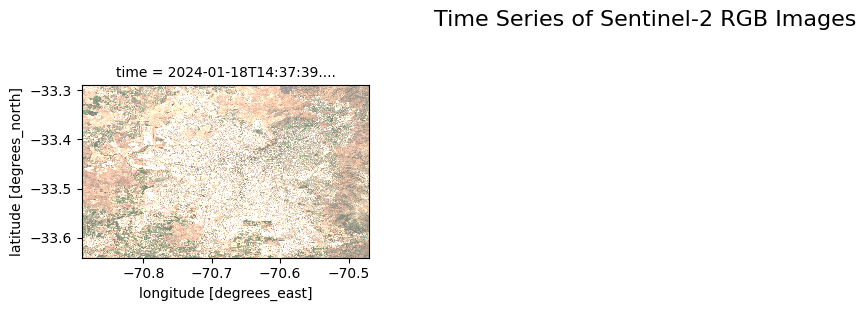

🧮 Computing median composite...
🌿 Calculating NDVI, NDBI, NDWI...


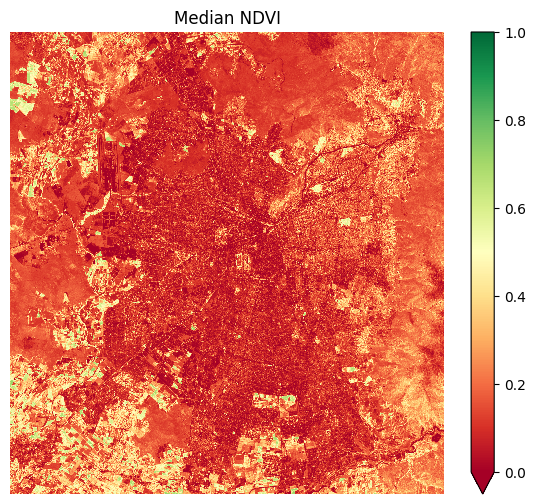

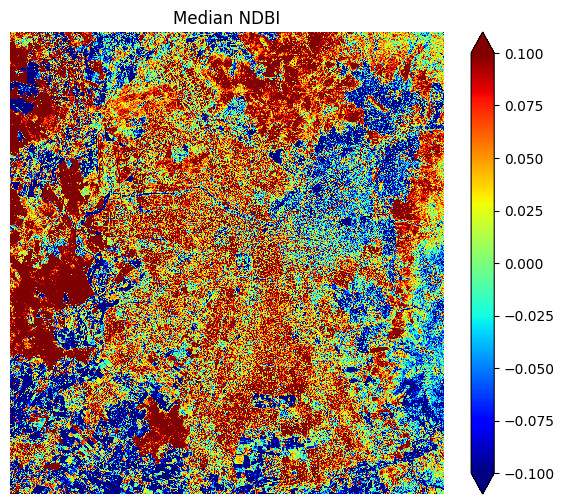

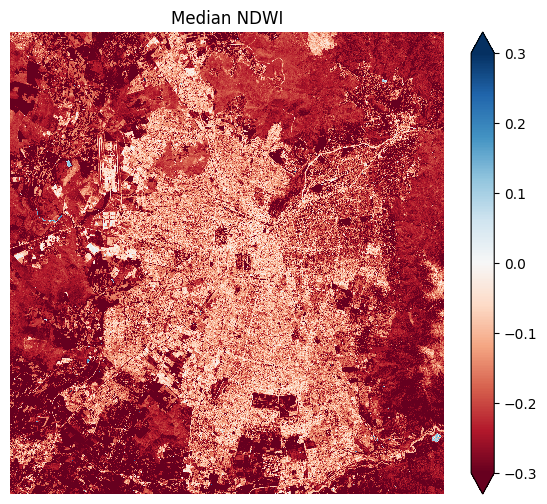

💾 Saving GeoTIFF to sample_chile.tiff...
💾 Saving GeoTIFF to ./Data/sample_chile.tiff...
✅ GeoTIFF saved: sample_chile.tiff


In [8]:
# Santiago, Chile
download_sentinel_geotiff(
    lower_left=(-33.64, -70.89),
    upper_right=(-33.29, -70.47),
    time_window="2024-01-18/2024-01-18",
    filename="sample_chile.tiff"
)

🔍 Searching STAC...
📦 Found 2 scenes.
📥 Loading data from STAC items...


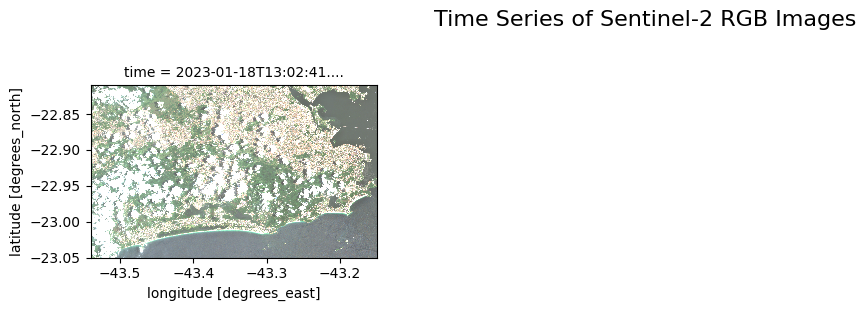

🧮 Computing median composite...
🌿 Calculating NDVI, NDBI, NDWI...


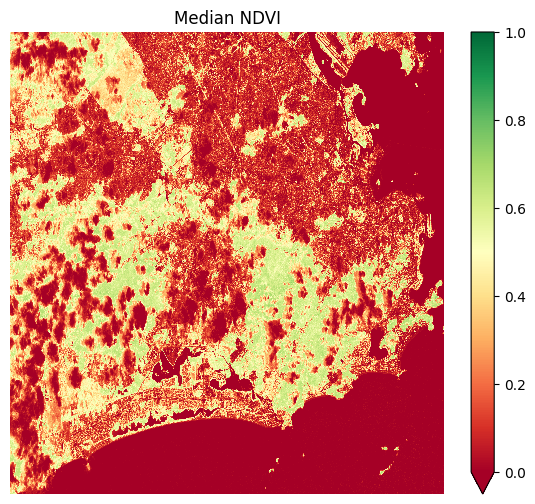

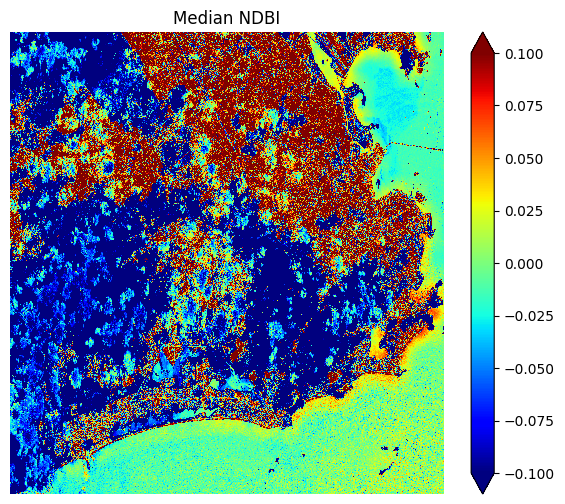

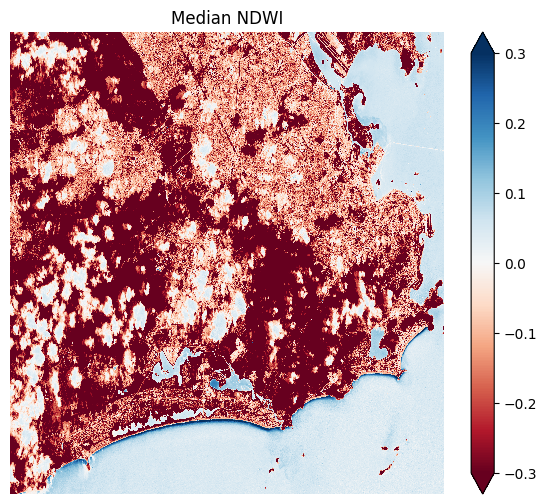

💾 Saving GeoTIFF to sample_Brazil.tiff...
💾 Saving GeoTIFF to ./Data/sample_Brazil.tiff...
✅ GeoTIFF saved: sample_Brazil.tiff


In [9]:
# Rio, Brazil
download_sentinel_geotiff(
    lower_left=(-23.05, -43.54),
    upper_right=(-22.81, -43.15),
    time_window="2023-01-18/2023-01-18",
    filename="sample_Brazil.tiff"
)

🔍 Searching STAC...
📦 Found 4 scenes.
📥 Loading data from STAC items...


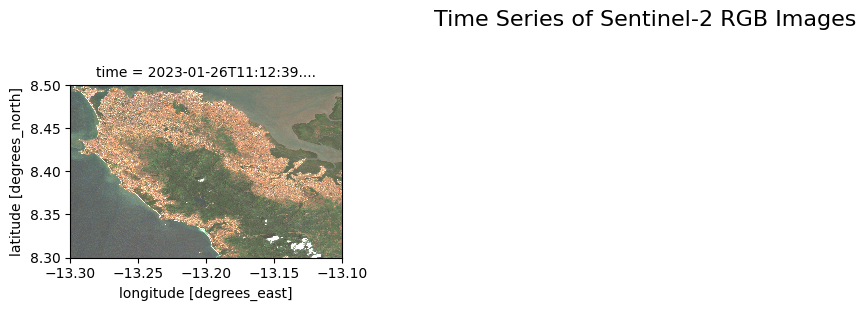

🧮 Computing median composite...
🌿 Calculating NDVI, NDBI, NDWI...


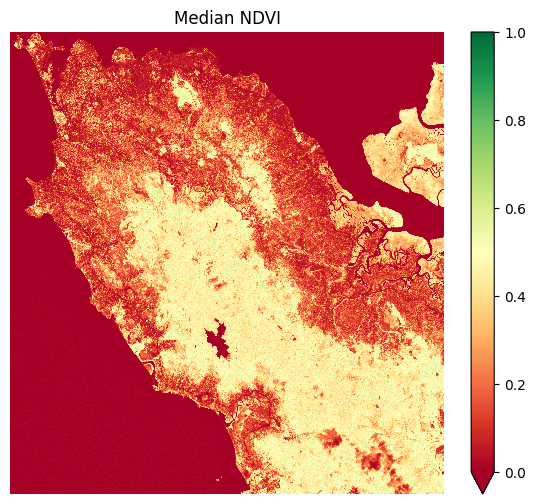

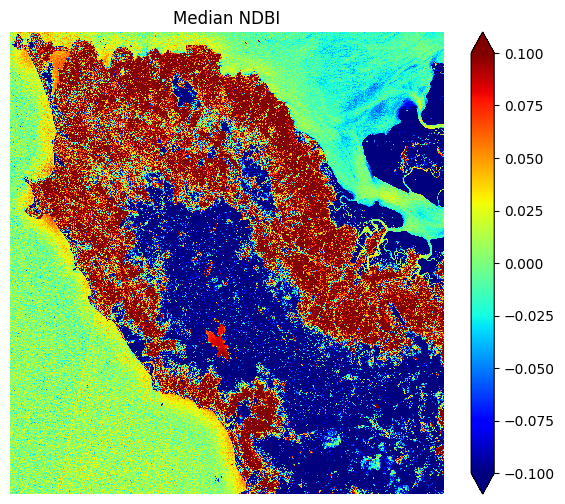

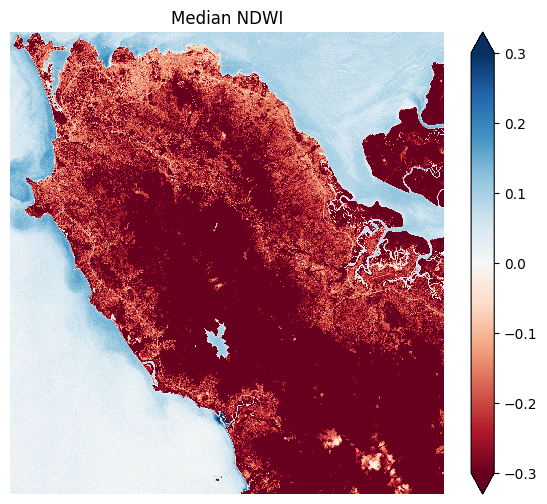

💾 Saving GeoTIFF to sample_Sierra.tiff...
💾 Saving GeoTIFF to ./Data/sample_Sierra.tiff...
✅ GeoTIFF saved: sample_Sierra.tiff


In [10]:
# Freetown, Sierra Leone
download_sentinel_geotiff(
    lower_left=(8.30, -13.30),
    upper_right=(8.50, -13.10),
    time_window="2023-01-26/2023-01-26",
    filename="sample_Sierra.tiff"
)

In [ ]:
import numpy as np
import xarray as xr
import rasterio
from rasterio.env import Env
from odc.stac import stac_load
from pystac_client import Client
from datetime import datetime

def download_sentinel_geotiff(
    lower_left,
    upper_right,
    time_window,
    filename,
    collection="sentinel-2-l2a",
    bands=("B04", "B08", "B11"),
    resolution=20,              # 🔑 safer than 10 m
    composite="mean",           # mean > median for stability
    crs="EPSG:4326",
):
    """
    Robust Sentinel-2 downloader using STAC + ODC
    Designed for large AOIs and cloud-hosted COGs
    """

    print("🔍 Connecting to STAC catalog...")
    catalog = Client.open("https://earth-search.aws.element84.com/v1")

    bbox = [
        lower_left[1],
        lower_left[0],
        upper_right[1],
        upper_right[0],
    ]

    search = catalog.search(
        collections=[collection],
        bbox=bbox,
        datetime=time_window,
        query={"eo:cloud_cover": {"lt": 20}},
        limit=10,
    )

    items = list(search.get_items())

    if len(items) == 0:
        raise RuntimeError("❌ No Sentinel-2 scenes found for this AOI/time window")

    print(f"📦 {len(items)} scenes selected")

    # -------------------------------
    # GDAL / Rasterio safety settings
    # -------------------------------
    with Env(
        VSI_CACHE=True,
        VSI_CACHE_SIZE=512_000_000,     # 512 MB cache
        GDAL_HTTP_MULTIRANGE="YES",
        GDAL_HTTP_RETRY=5,
        GDAL_HTTP_TIMEOUT=60,
    ):

        print("⬇️ Loading data (lazy)...")
        data = stac_load(
            items,
            bands=list(bands),
            bbox=bbox,
            crs=crs,
            resolution=resolution,
            chunks={"time": 1, "x": 1024, "y": 1024},
            fail_on_error=False,         # 🔑 do NOT crash on bad tiles
        )

        print("🧮 Computing composite...")
        if composite == "median":
            composite_ds = data.quantile(0.5, dim="time", skipna=True)
        else:
            composite_ds = data.mean(dim="time", skipna=True)

        composite_ds = composite_ds.compute()

    # --------------------------------
    # Index calculations (safe)
    # --------------------------------
    print("🌿 Calculating indices...")
    red = composite_ds["B04"]
    nir = composite_ds["B08"]
    swir = composite_ds["B11"]

    ndvi = (nir - red) / (nir + red)
    ndbi = (swir - nir) / (swir + nir)
    ndwi = (nir - swir) / (nir + swir)

    output = xr.Dataset(
        {
            "NDVI": ndvi,
            "NDBI": ndbi,
            "NDWI": ndwi,
        }
    )

    # --------------------------------
    # Export GeoTIFF (COG-friendly)
    # --------------------------------
    print("💾 Writing GeoTIFF...")
    output.rio.write_crs(crs, inplace=True)

    output.rio.to_raster(
        filename,
        driver="GTiff",
        compress="deflate",
        tiled=True,
        blockxsize=512,
        blockysize=512,
        BIGTIFF="IF_SAFER",
    )

    print(f"✅ Done: {filename}")


In [ ]:
def download_sentinel_geotiff(
    lower_left,
    upper_right,
    time_window,
    filename,
    resolution=20,
    composite="mean",
    crs="EPSG:4326",
):
    """
    Production-grade Sentinel-2 downloader (AWS Earth Search)
    Computes NDVI, NDBI, NDWI and saves GeoTIFF
    """

    # Bounding box (min_lon, min_lat, max_lon, max_lat)
    bbox = [
        lower_left[1],
        lower_left[0],
        upper_right[1],
        upper_right[0],
    ]

    print("🔍 Connecting to AWS Earth Search STAC...")
    catalog = Client.open("https://earth-search.aws.element84.com/v1")

    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox,
        datetime=time_window,
        query={"eo:cloud_cover": {"lt": 30}},
        limit=10,
    )

    items = list(search.get_items())
    print(f"📦 {len(items)} scenes found")

    if not items:
        raise RuntimeError("❌ No Sentinel-2 scenes found")

    with Env(
        VSI_CACHE=True,
        VSI_CACHE_SIZE=512_000_000,
        GDAL_HTTP_MULTIRANGE="YES",
        GDAL_HTTP_RETRY=5,
        GDAL_HTTP_TIMEOUT=60,
    ):
        print("📥 Loading Sentinel-2 data...")
        data = stac_load(
            items,
            bands=["red", "nir", "swir16"],  # ✅ CORRECT BANDS
            bbox=bbox,
            crs=crs,
            resolution=resolution,
            chunks={"time": 1, "x": 1024, "y": 1024},
            fail_on_error=False,
        )

        print("🧮 Computing composite...")
        if composite == "median":
            composite_ds = data.quantile(0.5, dim="time", skipna=True)
        else:
            composite_ds = data.mean(dim="time", skipna=True)

        composite_ds = composite_ds.compute()

    print("🌿 Calculating indices...")
    red = composite_ds["red"]
    nir = composite_ds["nir"]
    swir = composite_ds["swir16"]

    ndvi = (nir - red) / (nir + red)
    ndbi = (swir - nir) / (swir + nir)
    ndwi = (nir - swir) / (nir + swir)

    output = xr.Dataset(
        {
            "NDVI": ndvi,
            "NDBI": ndbi,
            "NDWI": ndwi,
        }
    )

    print(f"💾 Writing GeoTIFF → {filename}")
    output.rio.write_crs(crs, inplace=True)

    output.rio.to_raster(
        filename,
        driver="GTiff",
        compress="deflate",
        tiled=True,
        blockxsize=512,
        blockysize=512,
        BIGTIFF="IF_SAFER",
    )

    print("✅ Done:", filename)
